# Convolutional Neural Network
를 사용한 이미지 분류
## MNIST data 불러오기

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

path = '../../../'

train_dataset = datasets.MNIST(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=path, train=False, download=True, transform=transform)

batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN 만들기

In [3]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # image (14 * 14)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(64*7*7, 100) # 64(num of kernel) * (7 * 7)(image size)
        # self.dropout = nn.Dropout(0.4)
        # self.fc2 = nn.Linear(100, 10)
        
        self.features = nn.ModuleDict({
            'conv1' : nn.Conv2d(1, 32, kernel_size=3, stride = 1, padding=1),
            'pool1' : nn.MaxPool2d(kernel_size=2, stride=2),
            'conv2' : nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding=1),
            'pool2' : nn.MaxPool2d(kernel_size=2, stride=2)
        })

        self.classifier = nn.ModuleDict({
            'fc1' : nn.Linear(64 * 7 * 7, 100),
            'dropout' : nn.Dropout(p = 0.4),
            'fc2' : nn.Linear(100, 10),
        })        
        
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.pool(x)
        # x = self.conv2(x)
        # x = self.pool(x)
        # x = self.fc1(x.reshape(-1, 64*7*7))
        # x = self.dropout(x)
        # x = self.fc2(x)
        
        for layer in self.features.values():
            x = layer(x)
        x = x.reshape(-1, 64*7*7)    
        # x = x.reshape(x.size(0), -1)
        for layer in self.classifier.values():
            x = layer(x)
        return x

In [4]:
'''
# Accuracy ver.
import torch.optim as optim

def train(model, dataloader, learning_rate = 0.001):
    model.train()
    accuracy_list = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    correct = 0
    
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(outputs, 1)
        correct += predicted.eq(labels.view_as(predicted)).sum()

    data_num = len(dataloader.dataset)
    accuracy = 100 * correct.to('cpu') / data_num
    print("Accuracy in training : {}/{} ({:.2f}%)".format(correct, data_num, accuracy))
    accuracy_list.append(accuracy)
        
    return accuracy_list

def eval(model, dataloader):
    model.eval()
    correct = 0
    accuracy_list = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            
            outputs = model(data)
            
            predicted = torch.argmax(outputs, 1)
            correct += predicted.eq(labels.view_as(predicted)).sum()

    data_num = len(dataloader.dataset)
    accuracy = 100 * correct.to('cpu') / data_num
    print("Accuracy in evaluation : {}/{} ({:.2f}%)".format(correct, data_num, accuracy))
    accuracy_list.append(accuracy)
    return accuracy_list
'''
print()

In [5]:
# Loss ver.
import torch.optim as optim

def train(model, dataloader, learning_rate = 0.001):
    model.train()
    train_loss = 0.0
    
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(dataloader.dataset)
    print(f"Loss in {'training':10s} : {train_loss:.4f}")
    return train_loss

def eval(model, dataloader):
    model.eval()
    eval_loss = 0.0
    
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * data.size(0)
    
    eval_loss = eval_loss / len(dataloader.dataset)
    print(f"Loss in {'evaluation':10s} : {eval_loss:.4f}")
    return eval_loss

In [6]:
def CrossValidation(epoch, model, train_loader, val_loader):
    train_losses, val_losses = [], []
    for i in range(epoch):
        print(f"Epoch {i+1}")
        train_loss, val_loss = train(model, train_loader), eval(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    return train_losses, val_losses

=== Fold 1 ===
Epoch 1
Loss in training   : 0.2015
Loss in evaluation : 0.0776
Epoch 2
Loss in training   : 0.0896
Loss in evaluation : 0.0668
Epoch 3
Loss in training   : 0.0751
Loss in evaluation : 0.0640
=== Fold 2 ===
Epoch 1
Loss in training   : 0.0638
Loss in evaluation : 0.0484
Epoch 2
Loss in training   : 0.0533
Loss in evaluation : 0.0396
Epoch 3
Loss in training   : 0.0475
Loss in evaluation : 0.0467
=== Fold 3 ===
Epoch 1
Loss in training   : 0.0480
Loss in evaluation : 0.0344
Epoch 2
Loss in training   : 0.0417
Loss in evaluation : 0.0359
Epoch 3
Loss in training   : 0.0341
Loss in evaluation : 0.0380
=== Fold 4 ===
Epoch 1
Loss in training   : 0.0378
Loss in evaluation : 0.0232
Epoch 2
Loss in training   : 0.0336
Loss in evaluation : 0.0189
Epoch 3
Loss in training   : 0.0305
Loss in evaluation : 0.0221
=== Fold 5 ===
Epoch 1
Loss in training   : 0.0306
Loss in evaluation : 0.0089
Epoch 2
Loss in training   : 0.0254
Loss in evaluation : 0.0175
Epoch 3
Loss in training   : 

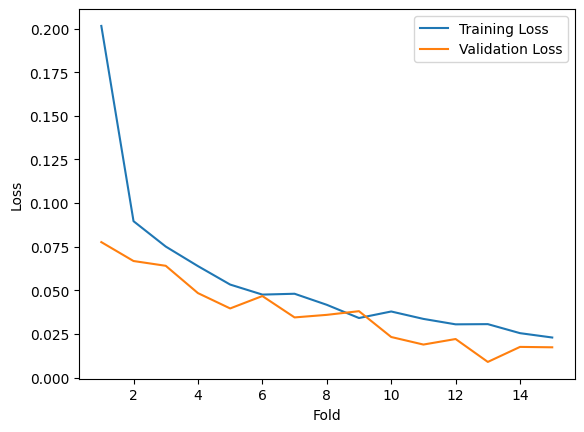

In [7]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

n = 5
kfold = StratifiedKFold(n, shuffle=True, random_state=42)

model = CNN().to(device)
train_losses, val_losses = [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset.data, train_dataset.targets)):
    print(f"=== Fold {fold + 1} ===")
    
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    train_loss, val_loss = CrossValidation(3, model, train_loader, val_loader)
    train_losses = train_losses + train_loss
    val_losses = val_losses + val_loss
    
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {correct}/{len(test_loader.dataset.data)} ({accuracy * 100:.2f}%)")

Test Accuracy: 9871/10000 (98.71%)


Predicted  : 7
True Label : 7


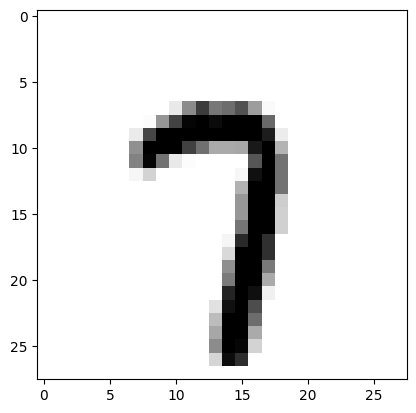

In [12]:
import random as r
idx = r.randint(0, len(test_dataset.data)-1)

image, label = test_dataset[idx]

plt.imshow(image.view(28,28), cmap ='gray_r')
image = image.to(device)

model.eval()
with torch.no_grad():
    output = model(image)

_, predicted = torch.max(output, 1)
print(f"{'Predicted':10s} : {predicted.item()}")
print(f"{'True Label':10s} : {label}")

In [10]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
torch.save(model.state_dict(),'CNN_save.pth')